<center><h1>In the name of Allah</h1></center>

Name: Mohammadjavad Maheronnaghsh


In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
# ! pip install torchattacks # needs to restart the Google Colab

## Train Resnet on CIFAR10 (15 pts)

In [4]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(num_cls=10).to(device)

################################ End #########################################

In [6]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 75

In [7]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################

model.train()

for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (i + 1)
        progress_bar.set_postfix({'Average Loss': avg_loss})

################################ End #########################################

Epoch 1/75:   0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 75/75: 100%|██████████| 391/391 [00:19<00:00, 19.85it/s, Average Loss=8.55e-5]


In [8]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

def evaluate(model, test_loader):
  model.eval()
  with torch.no_grad():
    total = 0.0
    correct = 0.0
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Test Accuracy: {100 * correct / total} %')
  return 100 * correct / total

################################ End #########################################

In [9]:
a=evaluate(model, testloader)

Test Accuracy: 75.04 %


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [10]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [11]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
from torchattacks import FGSM

def evaluate_adversasrial(attack, test_loader, attack_type):
  correct = 0
  total = 0
  model.eval()
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      adv_images = attack(images, labels)
      outputs = model(adv_images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  if attack_type == "FGSM":
    print(f'epsilon: {attack.eps:.6f}, Accuracy: {100 * correct / total}')
  elif attack_type == "PGD":
    print(f'k: {attack.steps:.6f}, Accuracy: {100 * correct / total}')


epsilon = 1/255
attack = FGSM(model, eps=epsilon)
a=evaluate_adversasrial(attack, testloader, "FGSM")


################################ End #########################################

epsilon: 0.003922, Accuracy: 52.91


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [13]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################

epsilon = 4/255
attack = FGSM(model, eps=epsilon)
evaluate_adversasrial(attack, testloader, "FGSM")

################################ End #########################################

epsilon: 0.015686, Accuracy: 23.14


In [14]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################

epsilon = 8/255
attack = FGSM(model, eps=epsilon)
evaluate_adversasrial(attack, testloader, "FGSM")


################################ End #########################################

epsilon: 0.031373, Accuracy: 10.97


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [15]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        # print(image)

        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()#.detach()
        perturbed_image.to(device)
        perturbed_image.requires_grad = True

        # if pred.item() == label.item():
        if True:
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################

            loss_fn = torch.nn.CrossEntropyLoss()
            # print(perturbed_image)

            for _ in range(self.steps):

                out = self.model(perturbed_image)
                self.model.zero_grad()

                loss = loss_fn(out, label)
                loss.backward()
                gradient = perturbed_image.grad.data
                perturbed_image = perturbed_image + self.alpha * torch.sign(gradient)
                perturbation = torch.clamp(perturbed_image - image, min=-self.epsilon, max=self.epsilon)
                perturbed_image = torch.clamp(image + perturbation, min=0, max=1).detach_()
                # print(type(perturbed_image))
                perturbed_image.requires_grad = True
                # print(type(perturbed_image))
            perturbation = torch.clamp(perturbed_image - image, min=-self.epsilon, max=self.epsilon)
            perturbed_image = torch.clamp(image + perturbation, min=0, max=1).detach()
            ################################ End #########################################

        return perturbed_image

In [16]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

# Your code goes here

for k in k_list:
    print(f'PGD attack with k={k}')
    attack = LinfPGDAttack(model, k=k)
    _ = evaluate_adversasrial(attack, testloader, "PGD")

################################ End #########################################

PGD attack with k=2
k: 2.000000, Accuracy: 15.81
PGD attack with k=4
k: 4.000000, Accuracy: 2.81
PGD attack with k=8
k: 8.000000, Accuracy: 0.65


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [17]:
##############################################################################
# Implement the function described                                           #
##############################################################################

# def plot_adversarial_examples(model, images, adv_images, labels, class_names):
#     model.eval()


import matplotlib.pyplot as plt

def run_attack_and_plot(attack_type, model, images, labels, epsilon=8/255, alpha=2/255, k=8):
    model.eval()

    if attack_type == "FGSM":
        attack = FGSM(model, eps=epsilon)
    elif attack_type == "PGD":
        attack = LinfPGDAttack(model, epsilon=epsilon, alpha=alpha, k=8)
    else:
        raise ValueError("Not Supported")

    adversarial_images = attack(images, labels)
    class_names = [str(i) for i in range(10)]

    images = images.to(device)
    adversarial_images = adversarial_images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        original_outputs = model(images)
        adv_outputs = model(adversarial_images)

    _, original_preds = torch.max(original_outputs, 1)
    _, adv_preds = torch.max(adv_outputs, 1)

    plt.figure(figsize=(15, 6))

    for i in range(len(images)):
        plt.subplot(2, len(images), i + 1)
        plt.imshow(images[i].cpu().squeeze().permute(1, 2, 0), cmap='gray')
        plt.title(f"Original: {class_names[labels[i]]}\nPrediction: {class_names[original_preds[i]]}")
        plt.axis('off')

        plt.subplot(2, len(images), len(images) + i + 1)
        plt.imshow(adversarial_images[i].cpu().squeeze().permute(1, 2, 0), cmap='gray')
        plt.title(f"Adversarial Prediction: {class_names[adv_preds[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



################################ End #########################################

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


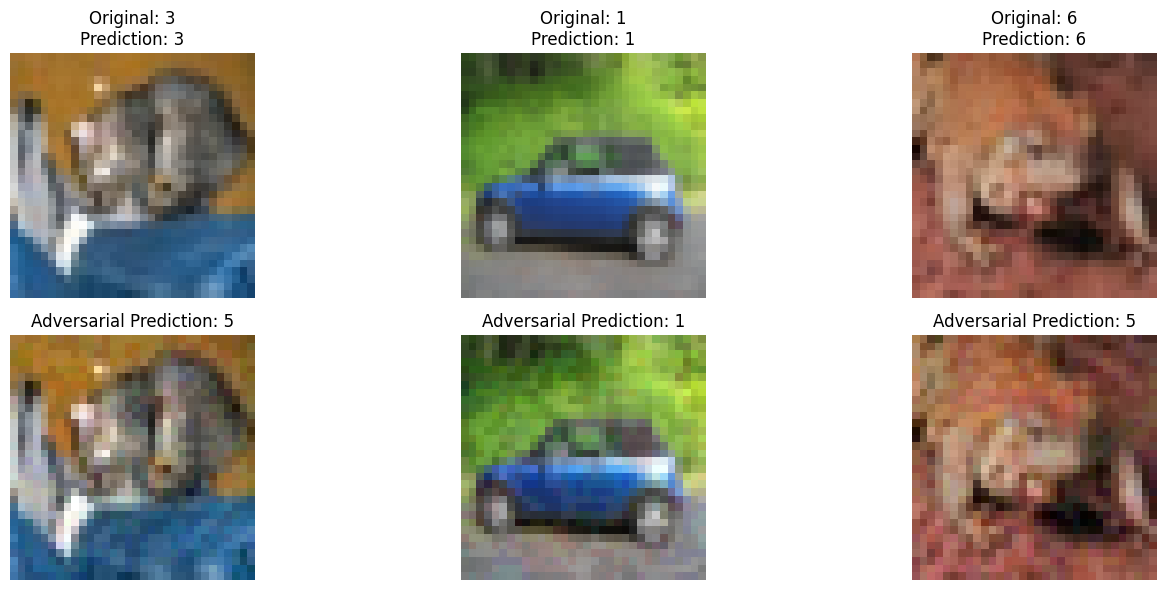

In [18]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
import random
all_images, all_labels = next(iter(testloader))
random_indices_FGSM = random.sample(range(len(all_images)), 3)
example_images_FGSM = all_images[random_indices_FGSM]
example_labels_FGSM = all_labels[random_indices_FGSM]

a=run_attack_and_plot("FGSM", model, example_images_FGSM.to(device), example_labels_FGSM.to(device))

################################ End #########################################

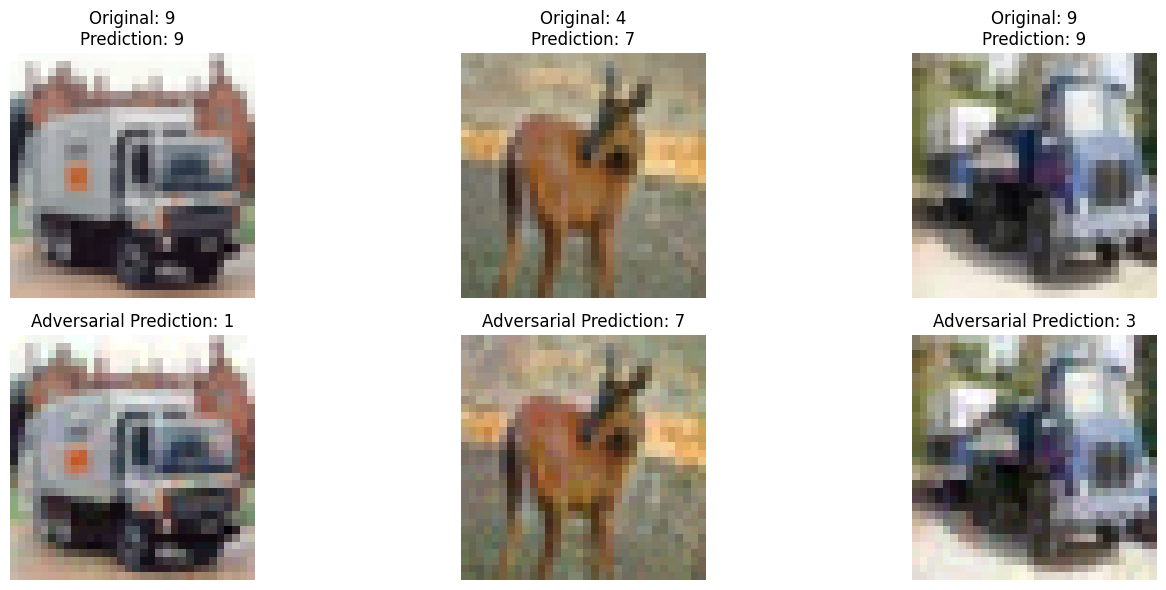

In [19]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

all_images, all_labels = next(iter(testloader))
random_indices_FGSM = random.sample(range(len(all_images)), 3)
example_images_FGSM = all_images[random_indices_FGSM]
example_labels_FGSM = all_labels[random_indices_FGSM]

run_attack_and_plot("PGD", model, example_images_FGSM.to(device), example_labels_FGSM.to(device))


################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [20]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(num_cls=10).to(device) # Your code goes here
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 75


# Your code goes here
adv_model.train()
epsilon = 8/255

for epoch in range(epochs):
  total_loss = 0
  with tqdm(total=len(trainloader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as progress_bar:
    counter = 0
    for images, labels in trainloader:
        counter += 1
        images, labels = images.to(device), labels.to(device)

        attack = FGSM(adv_model, eps=epsilon)
        adv_images = attack(images, labels)

        combined_images = torch.cat([images, adv_images])
        combined_labels = torch.cat([labels, labels])

        outputs = adv_model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / (counter)
        a=progress_bar.set_postfix({'Average Loss': avg_loss})
        # progress_bar.set_postfix(loss=total_loss/((progress_bar.n+1)*len(images)))
        a=progress_bar.update(1)

  # print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(trainloader):.4f}')


################################ End #########################################

Epoch 75/75: 100%|██████████| 391/391 [00:50<00:00,  7.80batch/s, Average Loss=0.048]


In [21]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Your code goes here
a=evaluate(adv_model, testloader)

################################ End #########################################

Test Accuracy: 63.13 %


In [22]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Your code goes here
epsilon = 8/255
attack = FGSM(adv_model, eps=epsilon)
a=evaluate_adversasrial(attack, testloader, "FGSM")
################################ End #########################################

epsilon: 0.031373, Accuracy: 61.53


In [23]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Your code goes here
attack = LinfPGDAttack(adv_model, k=4)
a=evaluate_adversasrial(attack, testloader, "PGD")

################################ End #########################################

k: 4.000000, Accuracy: 61.67


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
- What do you conclude from the result of the PGD attack on the adversarially trained model?
- What is you final conclusion?

ANSWER:

*   Clean Accuracy decreased a little, but the adversarial accuracy goes up. Overally, when we are training on adversarial examples, the accuracy on the clean data approximately the same (or decrease a little) but the accuracy on adversarial data increases a lot, in other words, the adversarial accuracy becomes much better. The clean accuracy on the normal model was 75.04% and now it is 63.13%.
*   It is very good, 61.53 %  near to clean accuracy 63.13 %. We expected from the model to be robust to the FGSM attack which we trained on adversarials generated from FGSM attack.
*   It is very good, 61.67 %  near to clean accuracy 63.13 %. Although we haven't trained on adversarial PGD (we trained on Adv FGSM), but it is resistent to PGD, too. So adversariality has the power of transferability.
Another important point is that the robust accuracy is less because PGD is more powerful than FGSM.
*   It is a good solution to train the model on perturbed images to be robust to adversarial examples.
Adversarial training (whether adversarial PGD training or adversarial FGSM training) is robust to adversarial attacks to some extent but note that they are not completely (100%) robust. Also note that the robustness has the power of tranferability as explained.
Finally note that PGD is more powerful than FGSM.

